# Minimum Dominating Set (MDS) Problem

The Minimum Dominating Set problem [[1]](#MDSWiki) is a classical NP-hard problem in computer science and graph theory. In this problem, we are given a graph, and we aim to find the smallest subset of vertices such that every node in the graph is either in the subset or is a neighbor of a node in the subset.

We represent the problem as a binary optimization problem.

### Variables:

- $x_i$ binary variables that represent whether a node $i$ is in the dominating set or not.

### Constraints:

- Every node $i$ is either in the dominating set or connected to a node in the dominating set:

  $\forall i \in V: x_i + \sum_{j \in N(i)} x_j \geq 1$

  Where $N(i)$ represents the neighbors of node $i$.

### Objective

- Minimize the size of the dominating set:

  $\sum_{i\in V}x_i$

## Solving with the Classiq platform

We go through the steps of solving the problem with the Classiq platform, using QAOA algorithm [[2](#QAOA)]. The solution is based on defining a pyomo model for the optimization problem we would like to solve.

In [1]:
import networkx as nx
import numpy as np
import pyomo.core as pyo
from matplotlib import pyplot as plt

### Building the Pyomo model from a graph input

We proceed by defining the pyomo model that will be used on the Classiq platform, using the mathematical formulation defined above:

In [2]:
def mds(graph: nx.Graph) -> pyo.ConcreteModel:
    model = pyo.ConcreteModel()
    model.x = pyo.Var(graph.nodes, domain=pyo.Binary)

    @model.Constraint(graph.nodes)
    def dominating_rule(model, idx):
        sum_of_neighbors = sum(model.x[neighbor] for neighbor in graph.neighbors(idx))
        return model.x[idx] + sum_of_neighbors >= 1

    model.cost = pyo.Objective(expr=sum(model.x.values()), sense=pyo.minimize)

    return model

The model contains:

- Index set declarations (model.Nodes, model.Arcs).
- Binary variable declaration for each node (model.x) indicating whether that node is chosen for the set.
- Constraint rule – for each node, it must be a part of the chosen set or be neighbored by one.
- Objective rule – the sum of the variables equals the set size.

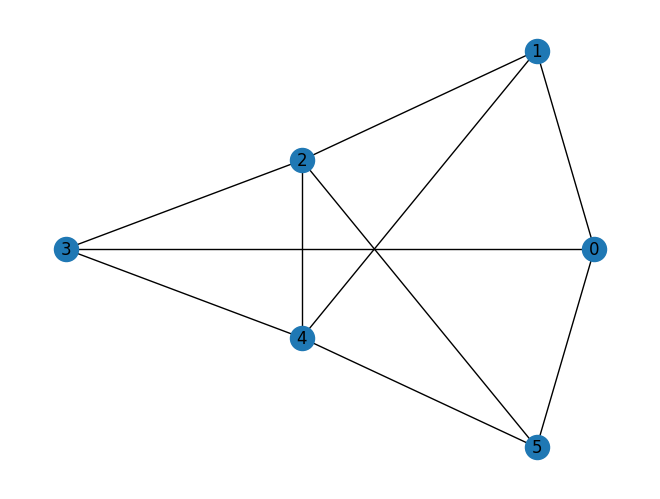

In [3]:
# generate a random graph
G = nx.erdos_renyi_graph(n=6, p=0.6, seed=8)
nx.draw_kamada_kawai(G, with_labels=True)

mds_model = mds(G)

In [4]:
mds_model.pprint()

1 Var Declarations
    x : Size=6, Index={0, 1, 2, 3, 4, 5}
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  None :     1 : False :  True : Binary
          1 :     0 :  None :     1 : False :  True : Binary
          2 :     0 :  None :     1 : False :  True : Binary
          3 :     0 :  None :     1 : False :  True : Binary
          4 :     0 :  None :     1 : False :  True : Binary
          5 :     0 :  None :     1 : False :  True : Binary

1 Objective Declarations
    cost : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : x[0] + x[1] + x[2] + x[3] + x[4] + x[5]

1 Constraint Declarations
    dominating_rule : Size=6, Index={0, 1, 2, 3, 4, 5}, Active=True
        Key : Lower : Body                             : Upper : Active
          0 :   1.0 :        x[1] + x[3] + x[5] + x[0] :  +Inf :   True
          1 :   1.0 :        x[0] + x[2] + x[4] + x[1] :  +Inf :   True
          2 

## Setting Up the Classiq Problem Instance

In order to solve the Pyomo model defined above, we use the `CombinatorialProblem` quantum object. Under the hood it tranlastes the Pyomo model to a quantum model of the QAOA algorithm, with a cost function translated from the Pyomo model. We can choose the number of layers for the QAOA ansatz using the argument `num_layers`, and the `penalty_factor`, which will be the coefficient of the constraints term in the cost hamiltonian.

In [5]:
from classiq import *
from classiq.applications.combinatorial_optimization import CombinatorialProblem

combi = CombinatorialProblem(pyo_model=mds_model, num_layers=6, penalty_factor=10)

qmod = combi.get_model()

## Synthesizing the QAOA Circuit and Solving the Problem

We can now synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [6]:
qprog = combi.get_qprog()
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/39FhnHoSwCsB4tSjvXSnQvo9TAl


https://platform.classiq.io/circuit/39FhnHoSwCsB4tSjvXSnQvo9TAl?login=True&version=17

We now solve the problem by calling the `optimize` method of the `CombinatorialProblem` object. For the classical optimization part of the QAOA algorithm we define the maximum number of classical iterations (`maxiter`) and the $\alpha$-parameter (`quantile`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[3](#cvar)]:

In [7]:
optimized_params = combi.optimize(maxiter=70, quantile=0.7)

We can check the convergence of the run:

Text(0.5, 1.0, 'Cost convergence')

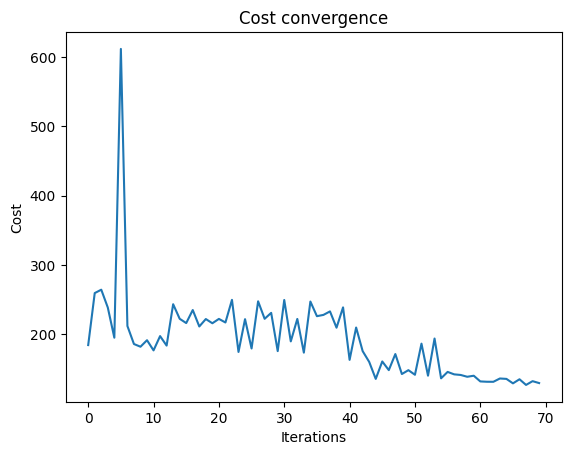

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=1)
axes.plot(combi.cost_trace)
axes.set_xlabel("Iterations")
axes.set_ylabel("Cost")
axes.set_title("Cost convergence")

## Optimization Results

We can also examine the statistics of the algorithm. In order to get samples with the optimized parameters, we call the `sample` method:

In [9]:
optimization_result = combi.sample(optimized_params)
optimization_result.sort_values(by="cost").head(5)

,solution,probability,cost
1068,"{'x': [1, 0, 0, 1, 0, 0], 'dominating_rule_0_s...",0.000488,2.0
1531,"{'x': [0, 0, 1, 1, 1, 0], 'dominating_rule_0_s...",0.000488,3.0
432,"{'x': [0, 1, 1, 0, 1, 0], 'dominating_rule_0_s...",0.000488,3.0
309,"{'x': [0, 0, 1, 0, 1, 1], 'dominating_rule_0_s...",0.000488,3.0
13,"{'x': [0, 1, 1, 0, 1, 0], 'dominating_rule_0_s...",0.000977,3.0


We will also want to compare the optimized results to uniformly sampled results:

In [10]:
uniform_result = combi.sample_uniform()

And compare the histograms:

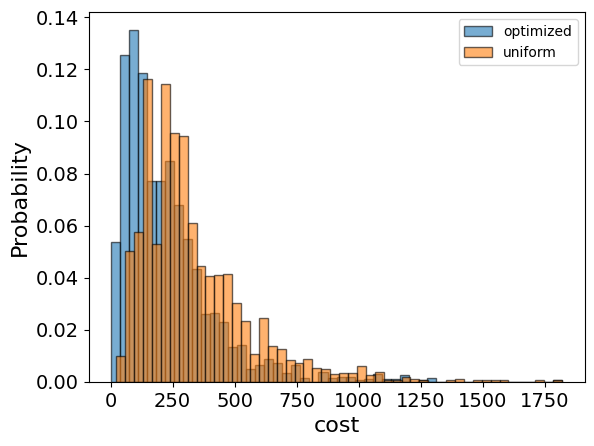

In [11]:
optimization_result["cost"].plot(
    kind="hist",
    bins=50,
    edgecolor="black",
    weights=optimization_result["probability"],
    alpha=0.6,
    label="optimized",
)
uniform_result["cost"].plot(
    kind="hist",
    bins=50,
    edgecolor="black",
    weights=uniform_result["probability"],
    alpha=0.6,
    label="uniform",
)
plt.legend()
plt.ylabel("Probability", fontsize=16)
plt.xlabel("cost", fontsize=16)
plt.tick_params(axis="both", labelsize=14)

Let us plot the solution:

In [12]:
best_solution = optimization_result.solution[optimization_result.cost.idxmin()]
best_solution

{'x': [1, 0, 0, 1, 0, 0],
 'dominating_rule_0_slack_var': [1, 0],
 'dominating_rule_1_slack_var': [0, 0],
 'dominating_rule_2_slack_var': [0, 0, 0],
 'dominating_rule_3_slack_var': [1, 0],
 'dominating_rule_4_slack_var': [0, 0, 0],
 'dominating_rule_5_slack_var': [0, 0]}

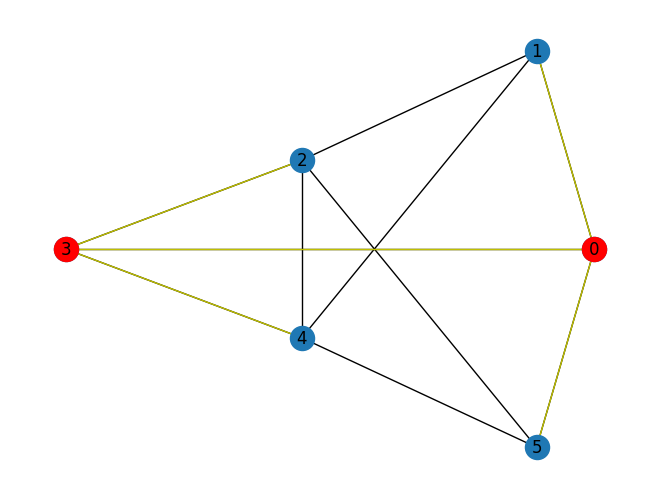

In [13]:
def draw_solution(graph: nx.Graph, solution: list):
    solution_nodes = [v for v in graph.nodes if solution[v]]
    solution_edges = [
        (u, v) for u, v in graph.edges if u in solution_nodes or v in solution_nodes
    ]
    nx.draw_kamada_kawai(graph, with_labels=True)
    nx.draw_kamada_kawai(
        graph,
        nodelist=solution_nodes,
        edgelist=solution_edges,
        node_color="r",
        edge_color="y",
    )


draw_solution(G, [best_solution["x"][i] for i in range(len(best_solution["x"]))])

Lastly, we can compare to the classical solution of the problem:

In [14]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(mds_model)

mds_model.display()
classical_solution = [int(pyo.value(mds_model.x[i])) for i in G.nodes]

Model unknown

  Variables:
    x : Size=6, Index={0, 1, 2, 3, 4, 5}
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   1.0 :     1 : False : False : Binary
          1 :     0 :   0.0 :     1 : False : False : Binary
          2 :     0 :   0.0 :     1 : False : False : Binary
          3 :     0 :   1.0 :     1 : False : False : Binary
          4 :     0 :   0.0 :     1 : False : False : Binary
          5 :     0 :   0.0 :     1 : False : False : Binary

  Objectives:
    cost : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True :   2.0

  Constraints:
    dominating_rule : Size=6
        Key : Lower : Body : Upper
          0 :   1.0 :  2.0 :  None
          1 :   1.0 :  1.0 :  None
          2 :   1.0 :  1.0 :  None
          3 :   1.0 :  2.0 :  None
          4 :   1.0 :  1.0 :  None
          5 :   1.0 :  1.0 :  None


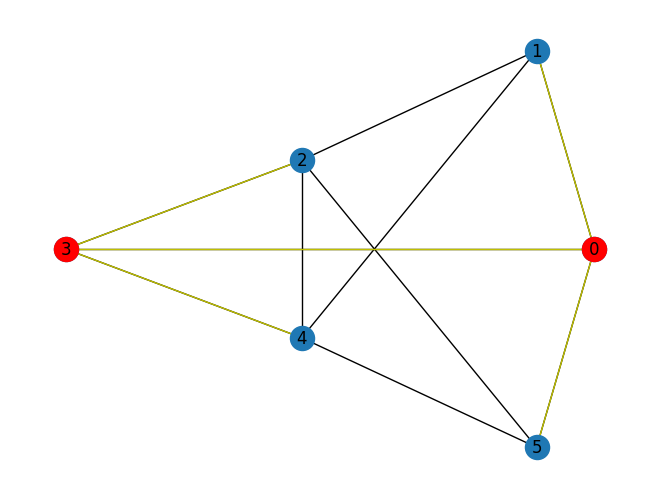

In [15]:
draw_solution(G, classical_solution)


## References

<a id='MDSWiki'>[1]</a>: [Dominating Set (Wikipedia)](https://en.wikipedia.org/wiki/Partition_problem)

<a id='QAOA'>[2]</a>: [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

<a id='cvar'>[3]</a>: [Barkoutsos, Panagiotis Kl, et al. "Improving variational quantum optimization using CVaR." Quantum 4 (2020): 256.](https://arxiv.org/abs/1907.04769)
